In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No willr LSTM Time Series - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-Cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4106, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[0.03424644, 0.56561183, 0.22432246],
       [0.31506791, 0.48559383, 0.49006783],
       [0.        , 0.19792211, 0.17891161],
       [0.28082311, 0.1505638 , 0.55203919],
       [0.73972344, 0.43087195, 0.85164683],
       [0.52739485, 0.5198189 , 0.46466227],
       [0.15068401, 0.33208159, 0.19175134],
       [0.14383571, 0.16844582, 0.05083703],
       [0.26712158, 0.11605662, 0.17165809],
       [0.16438226, 0.        , 0.        ],
       [0.58904107, 0.19827315, 0.30402389],
       [0.85616429, 0.55253441, 0.89587626],
       [0.5068483 , 0.6084195 , 0.66894449],
       [1.        , 1.        , 1.        ],
       [0.17808379, 0.75751779, 0.39220808]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4106,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 36ms/step - loss: 0.2973 - accuracy: 0.5368 - mse: 0.4576 - weighted_accuracy: 0.3134 - weighted_mse: 0.5413 - val_loss: 0.3016 - val_accuracy: 0.0450 - val_mse: 0.3485 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3485
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2162 - accuracy: 0.4147 - mse: 0.7225 - weighted_accuracy: 0.4219 - weighted_mse: 0.7452 - val_loss: 0.2942 - val_accuracy: 0.0450 - val_mse: 0.3725 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3725
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.2731 - mse: 0.9550 - weighted_accuracy: 0.4517 - weighted_mse: 0.9394 - val_loss: 0.2850 - val_accuracy: 0.0450 - val_mse: 0.4036 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4036
Epoch 4/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1831 - accuracy: 0.2561 - mse: 1.0949 - weighted_accuracy: 0.5014 - weighte

Epoch 30/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1386 - accuracy: 0.3834 - mse: 1.6493 - weighted_accuracy: 0.7012 - weighted_mse: 1.5481 - val_loss: 0.1779 - val_accuracy: 0.4234 - val_mse: 1.5944 - val_weighted_accuracy: 0.4234 - val_weighted_mse: 1.5944
Epoch 31/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1382 - accuracy: 0.4026 - mse: 1.6631 - weighted_accuracy: 0.6952 - weighted_mse: 1.5672 - val_loss: 0.2048 - val_accuracy: 0.2871 - val_mse: 1.6526 - val_weighted_accuracy: 0.2871 - val_weighted_mse: 1.6526
Epoch 32/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1370 - accuracy: 0.3965 - mse: 1.7061 - weighted_accuracy: 0.7125 - weighted_mse: 1.6055 - val_loss: 0.1770 - val_accuracy: 0.4246 - val_mse: 1.6465 - val_weighted_accuracy: 0.4246 - val_weighted_mse: 1.6465
Epoch 33/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1352 - accuracy: 0.4254 - mse: 1.6850 - weighted_accuracy: 0.7252 - weig

Epoch 59/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1143 - accuracy: 0.5670 - mse: 2.1201 - weighted_accuracy: 0.8115 - weighted_mse: 2.0719 - val_loss: 0.1770 - val_accuracy: 0.4903 - val_mse: 2.1504 - val_weighted_accuracy: 0.4903 - val_weighted_mse: 2.1504
Epoch 60/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1149 - accuracy: 0.5566 - mse: 2.1595 - weighted_accuracy: 0.7926 - weighted_mse: 2.0986 - val_loss: 0.1933 - val_accuracy: 0.4440 - val_mse: 2.2976 - val_weighted_accuracy: 0.4440 - val_weighted_mse: 2.2976
Epoch 61/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1133 - accuracy: 0.5569 - mse: 2.1615 - weighted_accuracy: 0.8055 - weighted_mse: 2.1066 - val_loss: 0.1605 - val_accuracy: 0.5876 - val_mse: 2.1389 - val_weighted_accuracy: 0.5876 - val_weighted_mse: 2.1389
Epoch 62/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1144 - accuracy: 0.5493 - mse: 2.2052 - weighted_accuracy: 0.7964 - weig

Epoch 88/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0963 - accuracy: 0.6629 - mse: 2.8209 - weighted_accuracy: 0.8529 - weighted_mse: 2.7992 - val_loss: 0.1826 - val_accuracy: 0.5523 - val_mse: 3.0605 - val_weighted_accuracy: 0.5523 - val_weighted_mse: 3.0605
Epoch 89/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.6526 - mse: 2.8188 - weighted_accuracy: 0.8600 - weighted_mse: 2.7960 - val_loss: 0.1552 - val_accuracy: 0.6168 - val_mse: 2.8278 - val_weighted_accuracy: 0.6168 - val_weighted_mse: 2.8278
Epoch 90/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0956 - accuracy: 0.6510 - mse: 2.8738 - weighted_accuracy: 0.8529 - weighted_mse: 2.8376 - val_loss: 0.1788 - val_accuracy: 0.5706 - val_mse: 2.9527 - val_weighted_accuracy: 0.5706 - val_weighted_mse: 2.9527
Epoch 91/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0930 - accuracy: 0.6617 - mse: 2.8294 - weighted_accuracy: 0.8675 - weig

Epoch 117/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0803 - accuracy: 0.7363 - mse: 3.7217 - weighted_accuracy: 0.8884 - weighted_mse: 3.6577 - val_loss: 0.1632 - val_accuracy: 0.6277 - val_mse: 4.0949 - val_weighted_accuracy: 0.6277 - val_weighted_mse: 4.0949
Epoch 118/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0788 - accuracy: 0.7357 - mse: 3.7540 - weighted_accuracy: 0.8881 - weighted_mse: 3.6957 - val_loss: 0.1667 - val_accuracy: 0.6314 - val_mse: 4.0260 - val_weighted_accuracy: 0.6314 - val_weighted_mse: 4.0260
Epoch 119/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0781 - accuracy: 0.7278 - mse: 3.7472 - weighted_accuracy: 0.8917 - weighted_mse: 3.6653 - val_loss: 0.1789 - val_accuracy: 0.5961 - val_mse: 4.0819 - val_weighted_accuracy: 0.5961 - val_weighted_mse: 4.0819
Epoch 120/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0787 - accuracy: 0.7393 - mse: 3.7662 - weighted_accuracy: 0.8917

Epoch 146/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0655 - accuracy: 0.8018 - mse: 4.9014 - weighted_accuracy: 0.9102 - weighted_mse: 4.7239 - val_loss: 0.1947 - val_accuracy: 0.5973 - val_mse: 5.0160 - val_weighted_accuracy: 0.5973 - val_weighted_mse: 5.0160
Epoch 147/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0633 - accuracy: 0.7835 - mse: 4.9400 - weighted_accuracy: 0.9143 - weighted_mse: 4.7697 - val_loss: 0.1587 - val_accuracy: 0.6861 - val_mse: 5.3292 - val_weighted_accuracy: 0.6861 - val_weighted_mse: 5.3292
Epoch 148/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0638 - accuracy: 0.8005 - mse: 4.9079 - weighted_accuracy: 0.9205 - weighted_mse: 4.6879 - val_loss: 0.1738 - val_accuracy: 0.6642 - val_mse: 5.3202 - val_weighted_accuracy: 0.6642 - val_weighted_mse: 5.3202
Epoch 149/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0620 - accuracy: 0.8072 - mse: 4.9629 - weighted_accuracy: 0.923

Epoch 175/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0512 - accuracy: 0.8484 - mse: 6.2977 - weighted_accuracy: 0.9402 - weighted_mse: 5.9479 - val_loss: 0.1952 - val_accuracy: 0.6630 - val_mse: 6.3299 - val_weighted_accuracy: 0.6630 - val_weighted_mse: 6.3299
Epoch 176/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0522 - accuracy: 0.8417 - mse: 6.2969 - weighted_accuracy: 0.9291 - weighted_mse: 5.9724 - val_loss: 0.1918 - val_accuracy: 0.6618 - val_mse: 6.3970 - val_weighted_accuracy: 0.6618 - val_weighted_mse: 6.3970
Epoch 177/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0529 - accuracy: 0.8389 - mse: 6.3870 - weighted_accuracy: 0.9345 - weighted_mse: 6.0251 - val_loss: 0.2037 - val_accuracy: 0.6557 - val_mse: 6.8187 - val_weighted_accuracy: 0.6557 - val_weighted_mse: 6.8187
Epoch 178/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0517 - accuracy: 0.8383 - mse: 6.4548 - weighted_accuracy: 0.934

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19632349908351898
Test accuracy: 0.6995133757591248


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.014284   -2.1478324   1.3421544 ]
 [-3.2093399   0.6816666  -1.3426853 ]
 [-2.190258   -0.62296134 -0.44118318]
 ...
 [-3.2150095  -3.489805    2.6007218 ]
 [-0.14198104 -4.4019775  -0.37148187]
 [-2.3659458  -1.0558137   0.02967881]]


Counter({2: 613, 1: 113, 0: 96})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 26
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 28
actual holds but predicted buy: 102
actual holds but predicted sell: 87
actual predicted holds: 559
Percentage buys correct: 24.324324324324323%
Percentage sells correct: 18.91891891891892%
Percentage holds correct: 74.73262032085562%
actual buys: 37
actual sells: 37
actual holds: 748


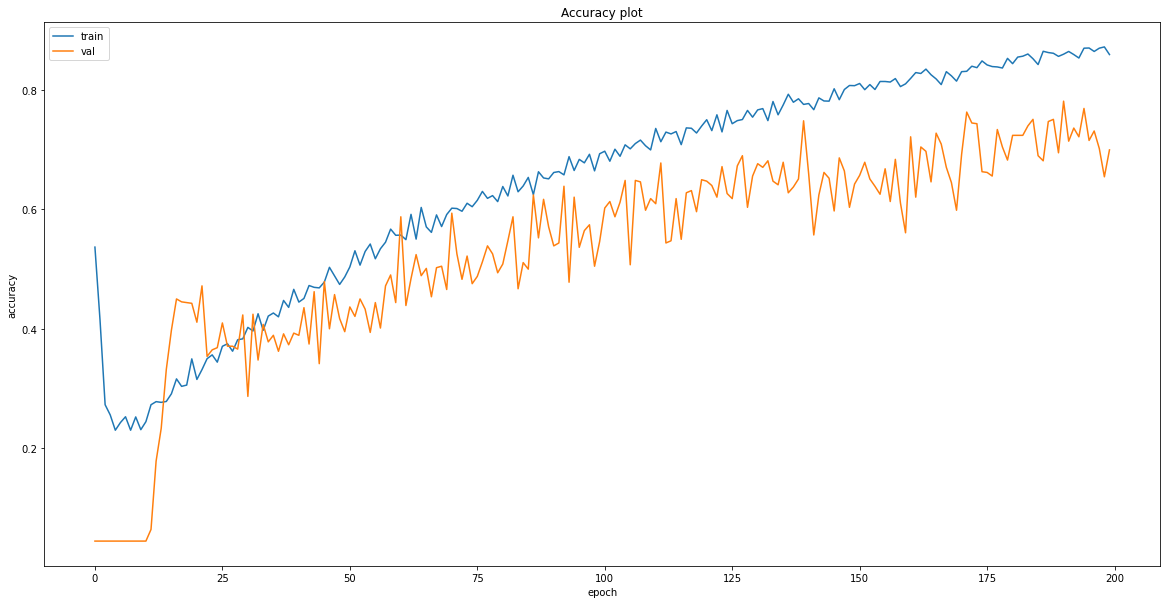

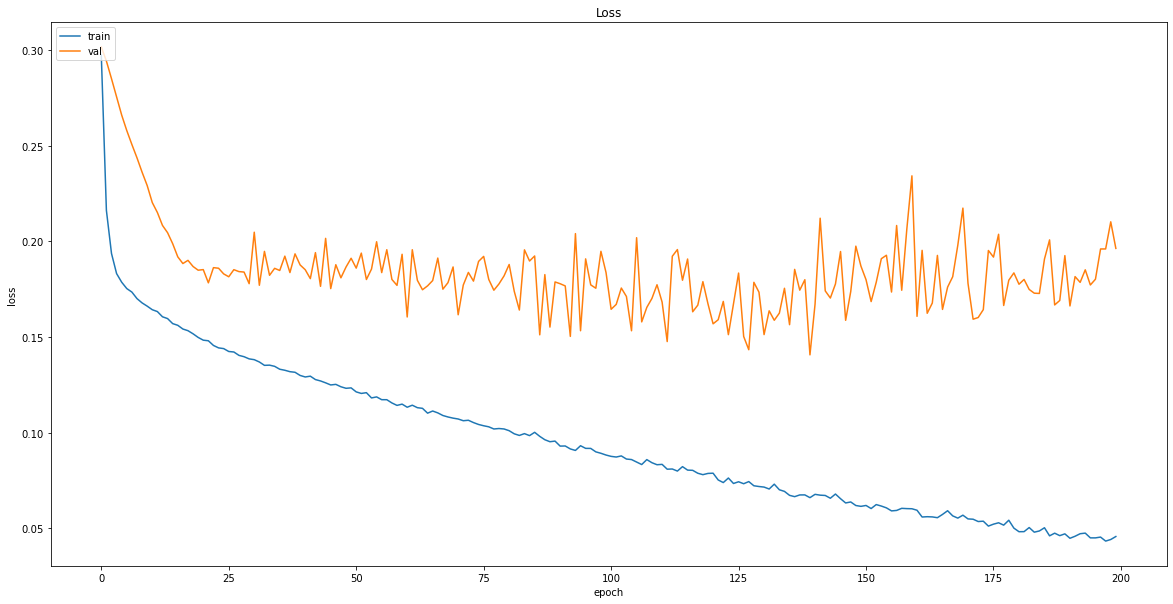

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_no_willr.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [26]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.7729 - mean_squared_error: 8.5101 - weighted_accuracy: 0.7729 - weighted_mean_squared_error: 8.5101
Test loss: 0.17786911129951477
Test accuracy: 0.772946834564209


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 1: 9, 0: 29})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [33]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [34]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-15,724.780029,700.682442,-8.071529,46243699.0,2.0,2,2
2019-02-18,740.000000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.760010,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.000000,713.082376,-17.677836,44744340.0,2.0,1,2
2019-02-21,720.250000,714.454318,-29.824573,40956103.0,2.0,1,2


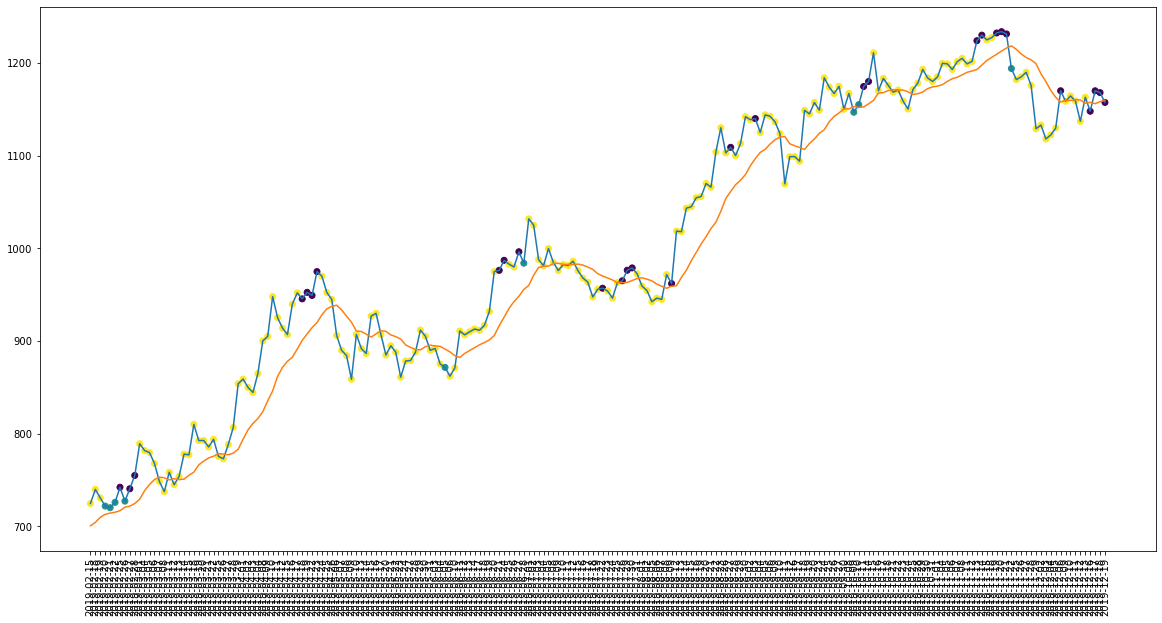

In [35]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 7
actual holds but predicted sell: 24
actual predicted holds: 154
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 83.24324324324324%
actual buys: 11
actual sells: 11
actual holds: 185


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 724.780029296875, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438]
[727.3499755859375, 740.7000122070312, 742.3300170898438, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 88.88888888888889%
Percentage sells correct: 65.51724137931035%
Percentage holds correct: 86.3905325443787%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $722.0
Shares owned at the moment: 13
Cash capital at the moment: $588.1885000000002


Price increase from previously bought: 30.596538190336673%
Share price: $945.5
Shares owned at the moment: 0
Cash capital at the moment: $12845.886875


Share price: $871.5999755859375
Shares owned at the moment: 14
Cash capital at the moment: $609.9306177368162


Price increase from previously bought: 11.705203432614496%
Share price: $976.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $14240.542897308349


Share price: $984.0
Shares owned at the moment: 14
Cash capital at the moment: $426.65889730834897


Stop Loss Activated!

Share price: $947.5
Shares owned at the moment: 0
Cash capital at the moment: $13655.180147308349


Share price: $1146.81005859375
Shares owned at the moment: 11
Cash capital at the moment: $1005.5784985046375


Price increase from previously bought: 6.4381343682337056%
Share price: $1224.0
Shares owned at the moment: 0
Cash capital at the

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15556.77199960327
profit gained: 55.56771999603271%


In [40]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%


### Recession

In [41]:
logger = []

In [42]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [43]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [44]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [45]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [47]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.6731 - mean_squared_error: 7.6769 - weighted_accuracy: 0.6731 - weighted_mean_squared_error: 7.6769
Test loss: 0.18784178793430328
Test accuracy: 0.6730769276618958


In [48]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 150, 1: 18, 0: 40})

In [49]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [50]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [51]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-18,1084.000000,1082.243470,-14.989967,2243205.0,2.0,2,2
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,0
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,2
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2


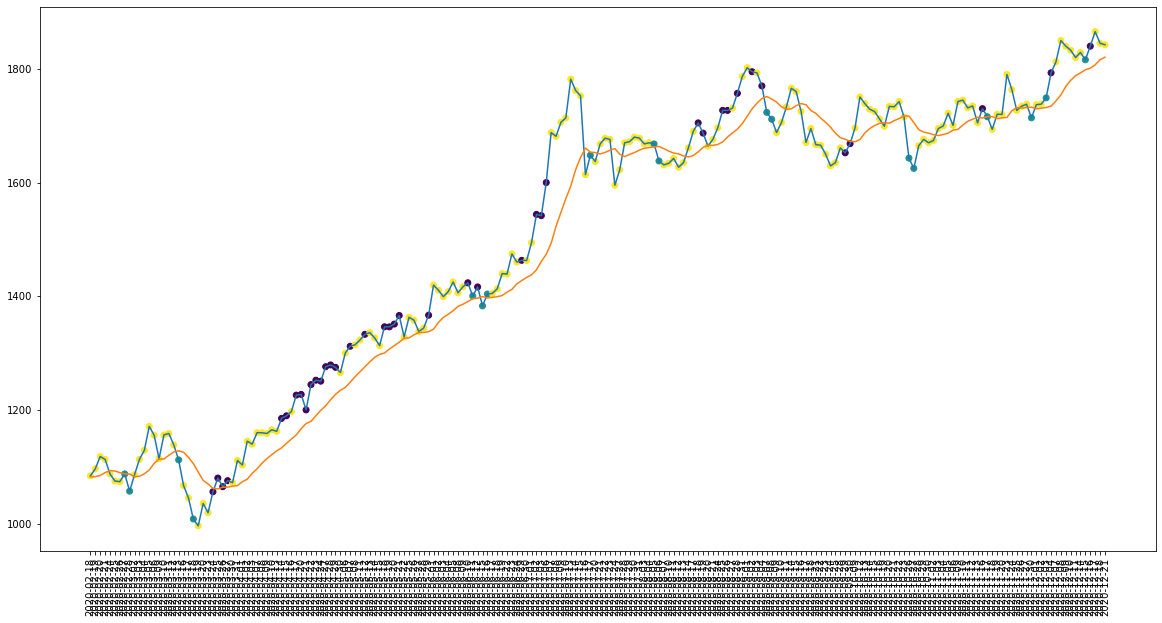

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 14
actual holds but predicted sell: 39
actual predicted holds: 136
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 0.0%
Percentage holds correct: 71.95767195767196%
actual buys: 9
actual sells: 10
actual holds: 189


In [54]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1084.0, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1073.699951171875, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1171.0]
Percentage buys correct: 77.77777777777777%
Percentage sells correct: 45.0%
Percentage holds correct: 84.0%


In [55]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1087.3900146484377
Shares owned at the moment: 9
Cash capital at the moment: $186.57696530151225


Stop Loss Activated!

Share price: $1057.0
Shares owned at the moment: 0
Cash capital at the moment: $9673.416215301511


Share price: $1057.0
Shares owned at the moment: 9
Cash capital at the moment: $134.2554653015104


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $9181.217625152585


Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $84.35996078491007


Price increase from previously bought: 6.859974498118526%
Share price: $1080.0999755859377
Shares owned at the moment: 0
Cash capital at the moment: $9778.527266662597


Share price: $1400.4599609375
Shares owned at the moment: 6
Cash capital at the moment: $1352.6599116821271


Price increase from previously bought: 9.94713789938928%
Share price: $1544.0
Shares owned at the moment: 0
Cash capital at the moment: $1059

In [56]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16754.069125
profit gained: 67.54069125000002%


In [57]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%


### Midea Group

In [58]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [59]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [60]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(1253, 15, 3)

In [63]:
y = labels
y = np.array(y)

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 101ms/step - loss: 0.3328 - accuracy: 0.5649 - mse: 0.3687 - weighted_accuracy: 0.3112 - weighted_mse: 0.4693 - val_loss: 0.3040 - val_accuracy: 0.0478 - val_mse: 0.3395 - val_weighted_accuracy: 0.0478 - val_weighted_mse: 0.3395
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2773 - accuracy: 0.5519 - mse: 0.4281 - weighted_accuracy: 0.3723 - weighted_mse: 0.4998 - val_loss: 0.3035 - val_accuracy: 0.0518 - val_mse: 0.3428 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.3428
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2434 - accuracy: 0.5110 - mse: 0.5129 - weighted_accuracy: 0.4641 - weighted_mse: 0.5522 - val_loss: 0.3018 - val_accuracy: 0.0518 - val_mse: 0.3462 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.3462
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2230 - accuracy: 0.4451 - mse: 0.6063 - weighted_accuracy: 0.4626 - weighted_mse: 

8/8 [==============================] - 0s 8ms/step - loss: 0.1427 - accuracy: 0.4810 - mse: 1.2938 - weighted_accuracy: 0.7234 - weighted_mse: 1.2548 - val_loss: 0.2266 - val_accuracy: 0.0518 - val_mse: 0.7019 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7019
Epoch 31/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1410 - accuracy: 0.4681 - mse: 1.2961 - weighted_accuracy: 0.7262 - weighted_mse: 1.2545 - val_loss: 0.2242 - val_accuracy: 0.0518 - val_mse: 0.7215 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7215
Epoch 32/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1402 - accuracy: 0.4970 - mse: 1.2902 - weighted_accuracy: 0.7444 - weighted_mse: 1.2553 - val_loss: 0.2227 - val_accuracy: 0.0518 - val_mse: 0.7418 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7418
Epoch 33/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1393 - accuracy: 0.4770 - mse: 1.3073 - weighted_accuracy: 0.7447 - weighted_mse: 1.2734 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.1140 - accuracy: 0.5988 - mse: 1.4821 - weighted_accuracy: 0.8249 - weighted_mse: 1.4395 - val_loss: 0.1767 - val_accuracy: 0.4861 - val_mse: 1.3477 - val_weighted_accuracy: 0.4861 - val_weighted_mse: 1.3477
Epoch 60/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.6048 - mse: 1.4870 - weighted_accuracy: 0.8282 - weighted_mse: 1.4393 - val_loss: 0.1750 - val_accuracy: 0.4980 - val_mse: 1.3774 - val_weighted_accuracy: 0.4980 - val_weighted_mse: 1.3774
Epoch 61/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.6198 - mse: 1.4843 - weighted_accuracy: 0.8261 - weighted_mse: 1.4379 - val_loss: 0.1695 - val_accuracy: 0.5418 - val_mse: 1.3788 - val_weighted_accuracy: 0.5418 - val_weighted_mse: 1.3788
Epoch 62/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1119 - accuracy: 0.6267 - mse: 1.4981 - weighted_accuracy: 0.8416 - weighted_mse: 1.4540 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0901 - accuracy: 0.7126 - mse: 1.8430 - weighted_accuracy: 0.8817 - weighted_mse: 1.8098 - val_loss: 0.1551 - val_accuracy: 0.6534 - val_mse: 1.5781 - val_weighted_accuracy: 0.6534 - val_weighted_mse: 1.5781
Epoch 89/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0909 - accuracy: 0.7116 - mse: 1.8445 - weighted_accuracy: 0.8802 - weighted_mse: 1.7840 - val_loss: 0.1505 - val_accuracy: 0.6733 - val_mse: 1.5615 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 1.5615
Epoch 90/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 0.7265 - mse: 1.8393 - weighted_accuracy: 0.8933 - weighted_mse: 1.8086 - val_loss: 0.1498 - val_accuracy: 0.6853 - val_mse: 1.6340 - val_weighted_accuracy: 0.6853 - val_weighted_mse: 1.6340
Epoch 91/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0877 - accuracy: 0.7176 - mse: 1.8731 - weighted_accuracy: 0.8900 - weighted_mse: 1.8215 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0706 - accuracy: 0.7844 - mse: 2.3783 - weighted_accuracy: 0.9145 - weighted_mse: 2.3402 - val_loss: 0.1607 - val_accuracy: 0.7052 - val_mse: 2.4145 - val_weighted_accuracy: 0.7052 - val_weighted_mse: 2.4145
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0705 - accuracy: 0.7844 - mse: 2.4145 - weighted_accuracy: 0.9145 - weighted_mse: 2.3680 - val_loss: 0.1682 - val_accuracy: 0.7052 - val_mse: 2.3774 - val_weighted_accuracy: 0.7052 - val_weighted_mse: 2.3774
Epoch 119/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.7834 - mse: 2.4439 - weighted_accuracy: 0.9206 - weighted_mse: 2.3785 - val_loss: 0.1620 - val_accuracy: 0.7052 - val_mse: 2.3334 - val_weighted_accuracy: 0.7052 - val_weighted_mse: 2.3334
Epoch 120/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.7994 - mse: 2.4237 - weighted_accuracy: 0.9265 - weighted_mse: 2.3466 -

Epoch 146/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0535 - accuracy: 0.8313 - mse: 3.2129 - weighted_accuracy: 0.9382 - weighted_mse: 3.0477 - val_loss: 0.1689 - val_accuracy: 0.7251 - val_mse: 3.2845 - val_weighted_accuracy: 0.7251 - val_weighted_mse: 3.2845
Epoch 147/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.8453 - mse: 3.2360 - weighted_accuracy: 0.9433 - weighted_mse: 3.0692 - val_loss: 0.1705 - val_accuracy: 0.7410 - val_mse: 3.1547 - val_weighted_accuracy: 0.7410 - val_weighted_mse: 3.1547
Epoch 148/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0535 - accuracy: 0.8593 - mse: 3.2716 - weighted_accuracy: 0.9484 - weighted_mse: 3.0570 - val_loss: 0.1627 - val_accuracy: 0.7729 - val_mse: 3.2938 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 3.2938
Epoch 149/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.8563 - mse: 3.3085 - weighted_accuracy: 0.9473 - weighted

Epoch 175/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0403 - accuracy: 0.8762 - mse: 4.1934 - weighted_accuracy: 0.9546 - weighted_mse: 3.8948 - val_loss: 0.1783 - val_accuracy: 0.7849 - val_mse: 4.2872 - val_weighted_accuracy: 0.7849 - val_weighted_mse: 4.2872
Epoch 176/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.8962 - mse: 4.2134 - weighted_accuracy: 0.9619 - weighted_mse: 3.8332 - val_loss: 0.1895 - val_accuracy: 0.7410 - val_mse: 4.0949 - val_weighted_accuracy: 0.7410 - val_weighted_mse: 4.0949
Epoch 177/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0397 - accuracy: 0.8992 - mse: 4.3334 - weighted_accuracy: 0.9630 - weighted_mse: 3.9554 - val_loss: 0.1795 - val_accuracy: 0.7729 - val_mse: 4.2431 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 4.2431
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.8882 - mse: 4.3641 - weighted_accuracy: 0.9590 - weighted

In [69]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.19659899175167084
Test accuracy: 0.788844645023346


In [70]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.9259479e+00 -1.1850599e+00  2.5417078e-01]
 [-8.1336439e-01 -2.7377586e+00 -8.5294552e-02]
 [-4.1396708e+00 -5.5903786e-01  9.8439378e-01]
 [-3.3397088e+00  1.2995704e+00 -1.6522754e+00]
 [-3.1794033e+00 -8.1060016e-01  1.5397824e-02]
 [-1.5905399e+00 -1.8439283e+00  6.7803532e-01]
 [-4.5873718e+00 -9.5338410e-01 -6.9843821e-02]
 [-1.3144641e+00 -2.9127936e+00  7.5022888e-01]
 [-1.7158780e+00 -2.3570342e+00  2.1652296e-01]
 [-6.6688299e-01 -4.5950046e+00  5.3786850e-01]
 [-9.0213239e-01 -3.3521624e+00  1.0817568e+00]
 [-2.4765003e+00 -4.2538610e+00  3.0389211e+00]
 [-1.9742138e+00 -3.7652586e+00  1.7581674e+00]
 [ 1.9353664e-01 -2.4223578e+00 -3.0637643e-01]
 [-2.4322646e+00 -3.8131564e+00  2.3033714e+00]
 [-1.0864625e+00 -3.7748179e+00 -3.7200215e-01]
 [-2.8685935e+00 -1.5117575e+00  8.1924289e-01]
 [-9.8633462e-01 -6.4104426e-01 -9.3413389e-01]
 [-3.0489419e+00 -2.9033797e+00  2.9417512e+00]
 [-1.7336626e+00 -2.0989237e+00  4.5505294e-01]
 [-3.2780468e+00 -2.9835207e+00  2.34776

Counter({2: 215, 1: 21, 0: 15})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [72]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 19
actual holds but predicted sell: 14
actual predicted holds: 195
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 10.0%
Percentage holds correct: 85.52631578947368%
actual buys: 13
actual sells: 10
actual holds: 228


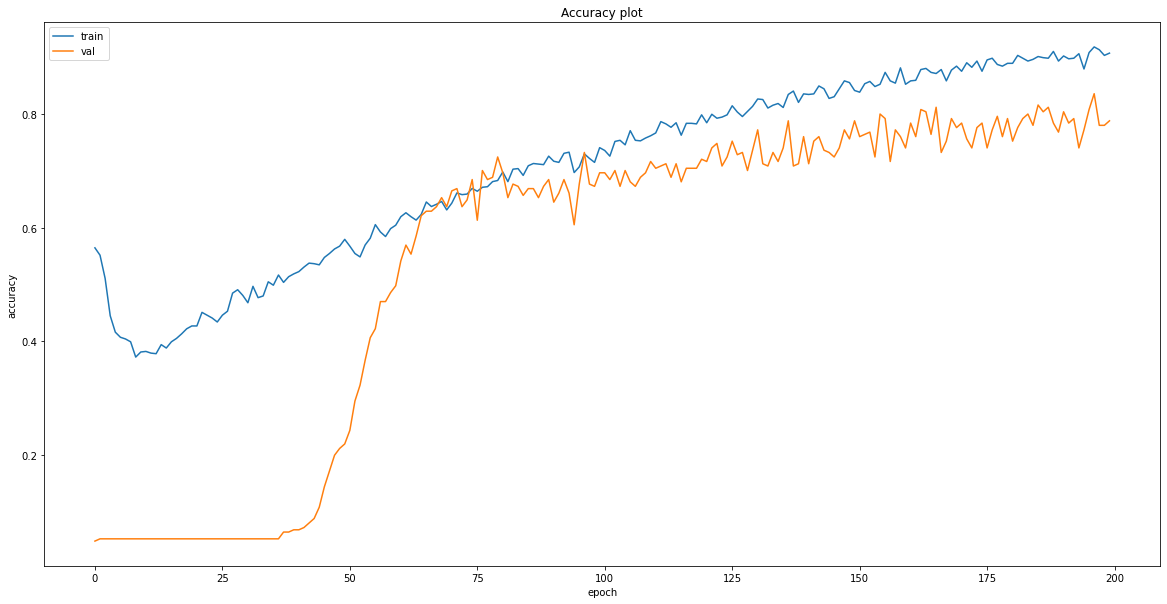

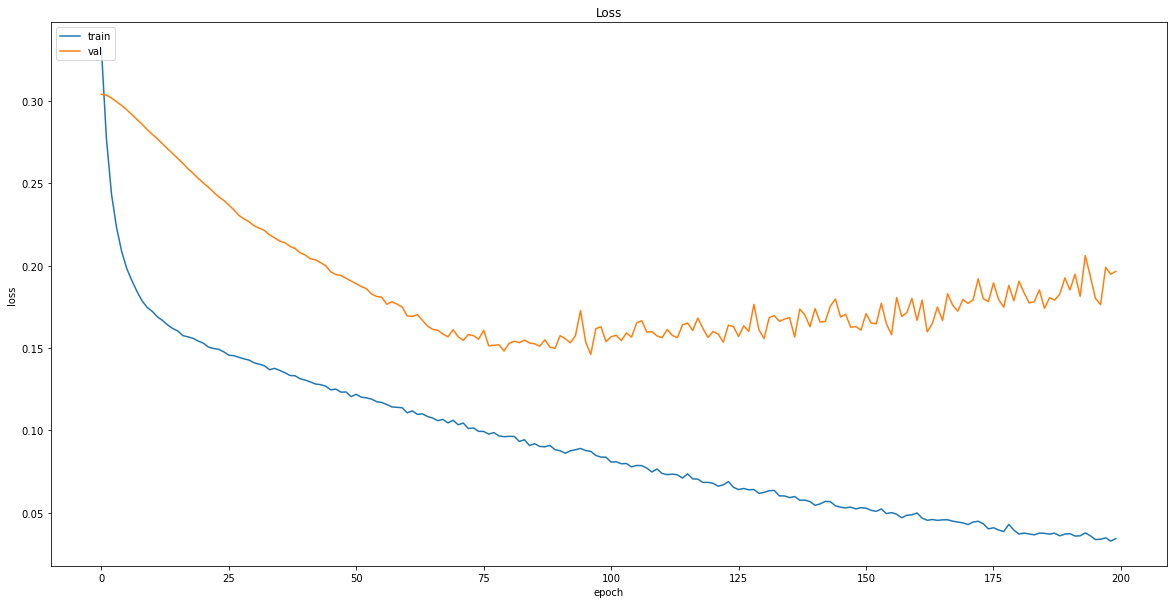

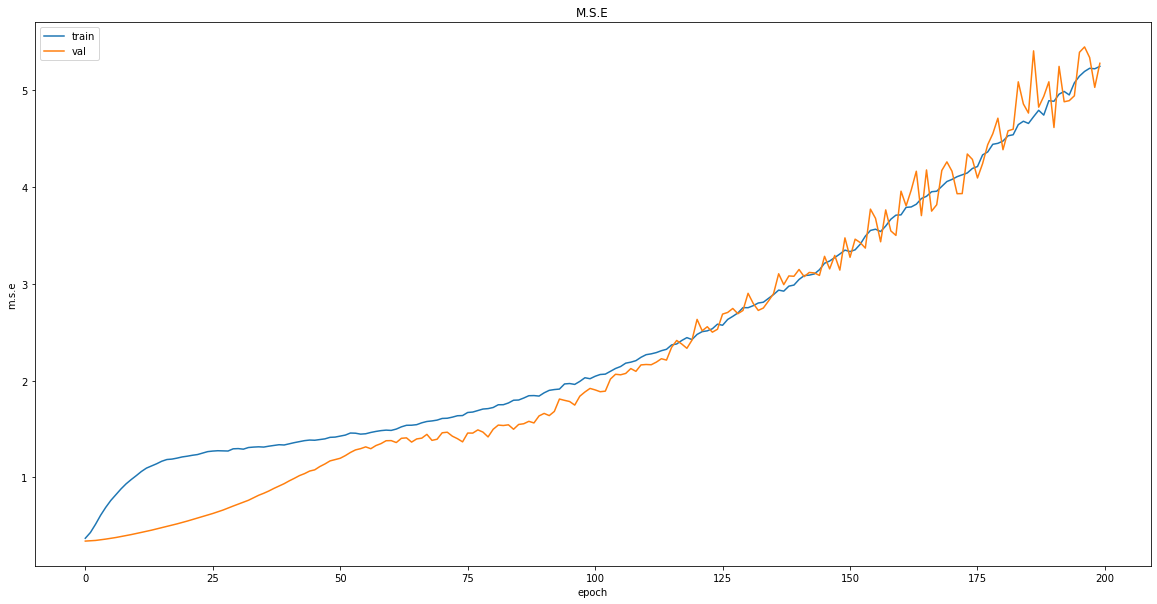

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [75]:
logger = []

In [76]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [77]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [81]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.7681 - mean_squared_error: 5.6101 - weighted_accuracy: 0.7681 - weighted_mean_squared_error: 5.6101
Test loss: 0.16481782495975494
Test accuracy: 0.7681159377098083


In [82]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 170, 1: 18, 0: 19})

In [83]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [84]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [85]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


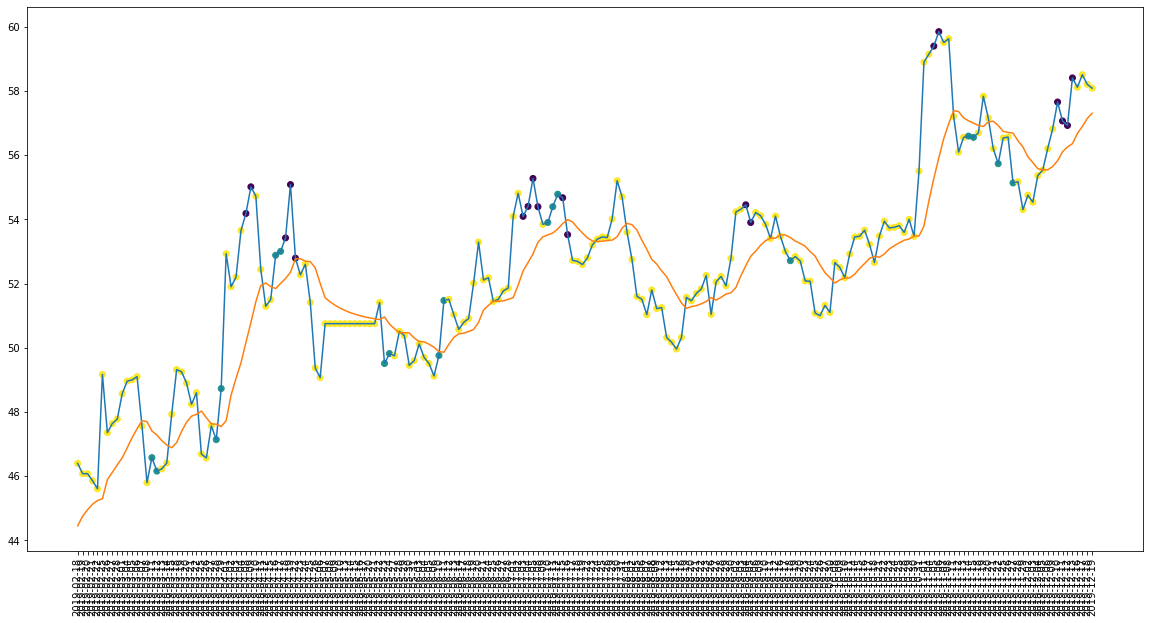

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

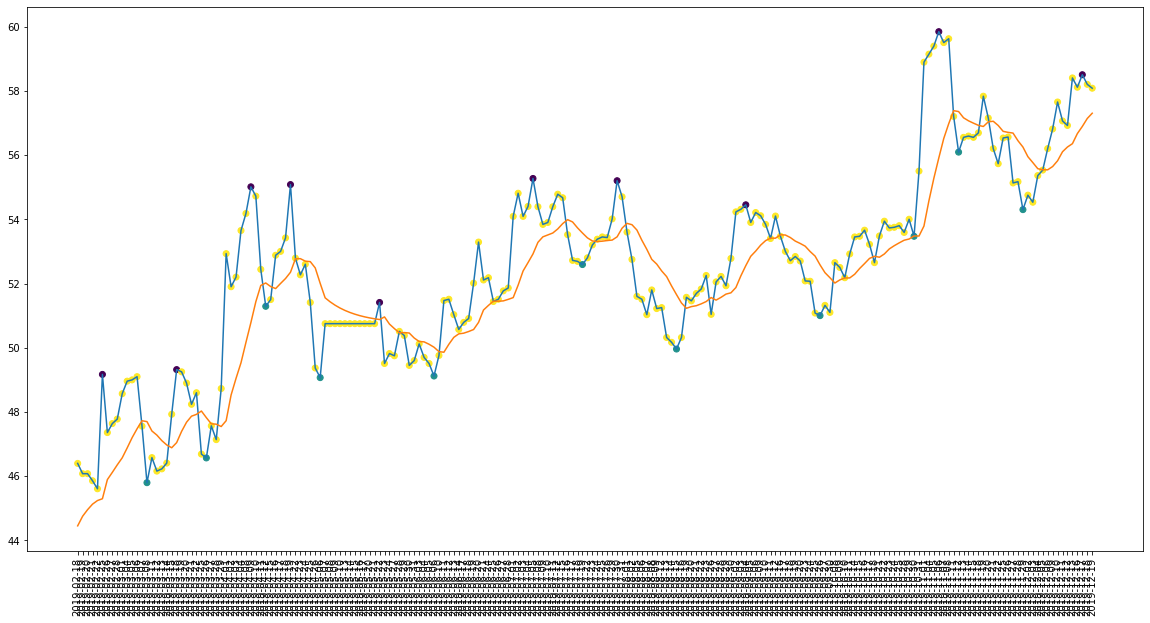

In [87]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 18
actual holds but predicted sell: 14
actual predicted holds: 154
Percentage buys correct: 0.0%
Percentage sells correct: 50.0%
Percentage holds correct: 82.79569892473118%
actual buys: 11
actual sells: 10
actual holds: 186


In [89]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 61.111111111111114%
Percentage sells correct: 63.1578947368421%
Percentage holds correct: 79.28994082840237%


In [90]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.58000183105469
Shares owned at the moment: 214
Cash capital at the moment: $4.467277076721075


Price increase from previously bought: 15.997019735799523%
Share price: $54.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $11567.102412204742


Share price: $52.88000106811523
Shares owned at the moment: 218
Cash capital at the moment: $7.560618715288001


Stop Loss Activated!

Share price: $51.40999984741211
Shares owned at the moment: 0
Cash capital at the moment: $11184.120290542603


Share price: $49.5099983215332
Shares owned at the moment: 225
Cash capital at the moment: $13.736356736184462


Price increase from previously bought: 8.951045071063568%
Share price: $54.09000015258789
Shares owned at the moment: 0
Cash capital at the moment: $12150.518203474046


Share price: $53.9000015258789
Shares owned at the moment: 224
Cash capital at the moment: $43.715460737232206


Stop Loss Activated!

Share price: $51.599998474121094
Shares owned at th

In [91]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [92]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%
2,0.768116,0.0%,50.0%,82.79569892473118%,61.111111111111114%,63.1578947368421%,79.28994082840237%,6.441581239719417%,24.380335833320625%


### recession

In [93]:
logger = []

In [94]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


In [95]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [96]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [97]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [98]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1766 - accuracy: 0.7404 - mean_squared_error: 5.5467 - weighted_accuracy: 0.7404 - weighted_mean_squared_error: 5.5467
Test loss: 0.17655879259109497
Test accuracy: 0.7403846383094788


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 166, 1: 19, 0: 23})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [102]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,1,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,1,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,1,2


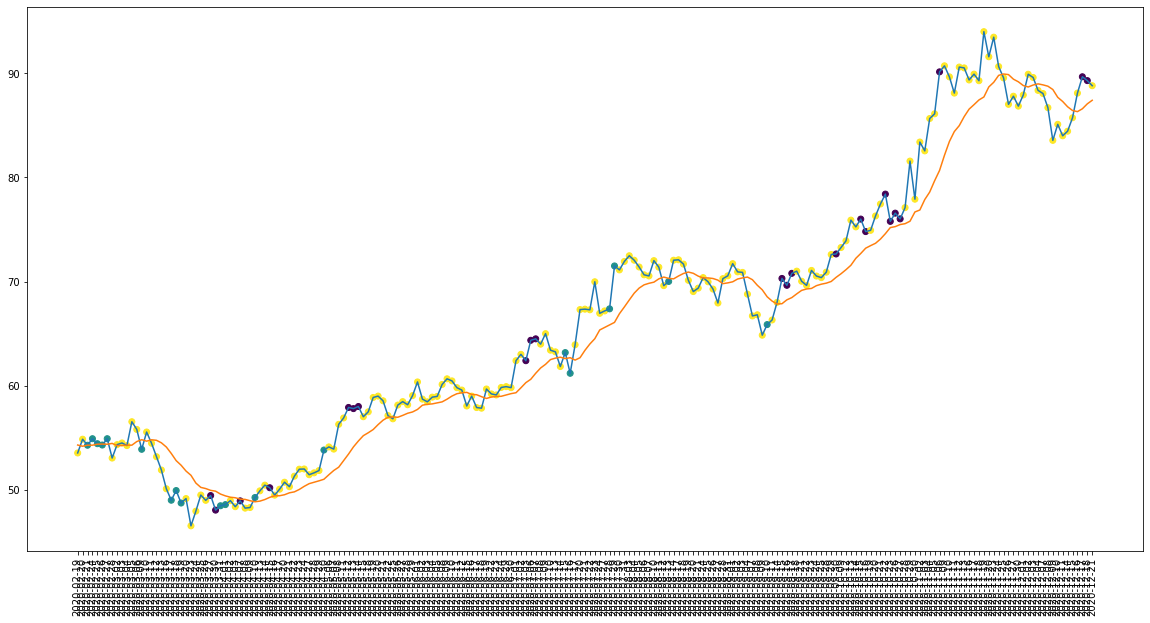

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

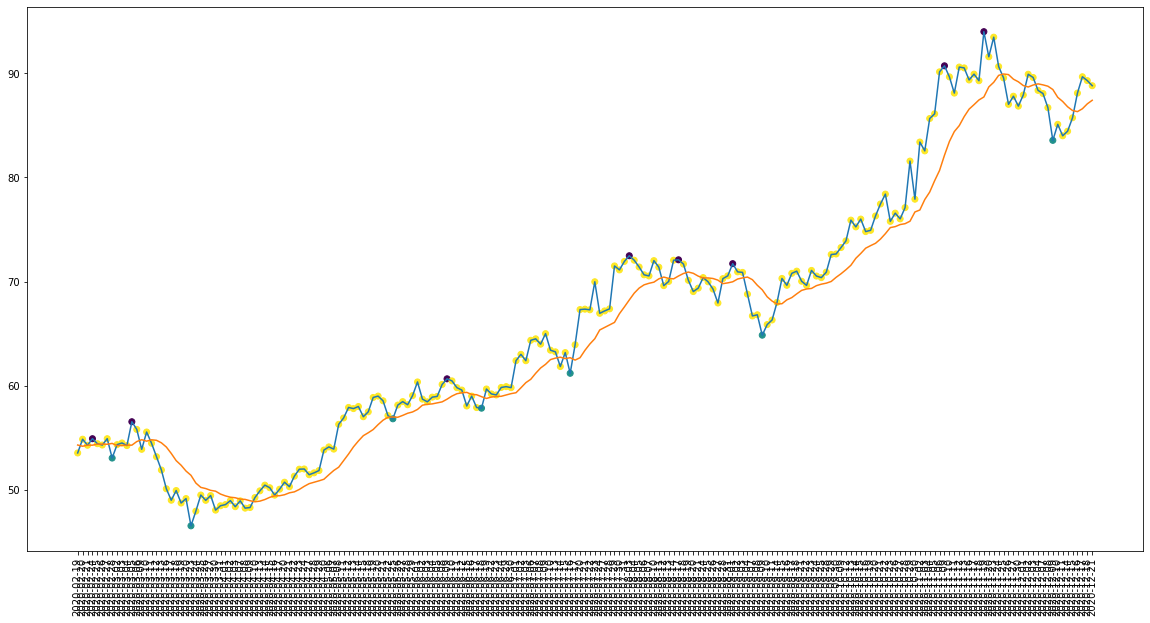

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 17
actual holds but predicted sell: 23
actual predicted holds: 153
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 0.0%
Percentage holds correct: 79.27461139896373%
actual buys: 7
actual sells: 8
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 57.89473684210526%
Percentage sells correct: 65.21739130434783%
Percentage holds correct: 84.24242424242425%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.27999877929688
Shares owned at the moment: 183
Cash capital at the moment: $39.4438140029888


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9511.025417470928


Share price: $49.0
Shares owned at the moment: 193
Cash capital at the moment: $28.01866747092754


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8985.537738681789


Share price: $48.47000122070313
Shares owned at the moment: 184
Cash capital at the moment: $42.53169345473543


Price increase from previously bought: 19.14830335612614%
Share price: $57.90999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10668.669205455773


Share price: $63.18000030517578
Shares owned at the moment: 168
Cash capital at the moment: $25.23999404525057


Stop Loss Activated!

Share price: $61.18999862670898
Shares owned at the moment: 0
Cash capital at the moment: $10276.8899839

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [110]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%
2,0.768116,0.0%,50.0%,82.79569892473118%,61.111111111111114%,63.1578947368421%,79.28994082840237%,6.441581239719417%,24.380335833320625%
3,0.740385,14.285714285714286%,0.0%,79.27461139896373%,57.89473684210526%,65.21739130434783%,84.24242424242425%,17.37873939679137%,64.87407351390837%


## Walmart

In [111]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


In [112]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [113]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,OBV_7,labels
Date,,,,
2000-01-21,63.3750,65.176128,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-30459400.0,2.0


In [114]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [115]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4745, 15, 3)

In [116]:
y = labels
y = np.array(y)

In [117]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [118]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [119]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [121]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2906 - accuracy: 0.5358 - mse: 0.4740 - weighted_accuracy: 0.3263 - weighted_mse: 0.5553 - val_loss: 0.3008 - val_accuracy: 0.0453 - val_mse: 0.3521 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3521
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2076 - accuracy: 0.2977 - mse: 0.8210 - weighted_accuracy: 0.4238 - weighted_mse: 0.8109 - val_loss: 0.2912 - val_accuracy: 0.0453 - val_mse: 0.3819 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3819
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1886 - accuracy: 0.2895 - mse: 1.0430 - weighted_accuracy: 0.4691 - weighted_mse: 1.0158 - val_loss: 0.2804 - val_accuracy: 0.0453 - val_mse: 0.4182 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4182
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1824 - accuracy: 0.3130 - mse: 1.1727 - weighted_accuracy: 0.4980 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1398 - accuracy: 0.3844 - mse: 1.6278 - weighted_accuracy: 0.7017 - weighted_mse: 1.5374 - val_loss: 0.2025 - val_accuracy: 0.3414 - val_mse: 1.6000 - val_weighted_accuracy: 0.3414 - val_weighted_mse: 1.6000
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1386 - accuracy: 0.3767 - mse: 1.6605 - weighted_accuracy: 0.6935 - weighted_mse: 1.5645 - val_loss: 0.2074 - val_accuracy: 0.2835 - val_mse: 1.7456 - val_weighted_accuracy: 0.2835 - val_weighted_mse: 1.7456
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1375 - accuracy: 0.4060 - mse: 1.6838 - weighted_accuracy: 0.7186 - weighted_mse: 1.5868 - val_loss: 0.1976 - val_accuracy: 0.3119 - val_mse: 1.7282 - val_weighted_accuracy: 0.3119 - val_weighted_mse: 1.7282
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.3970 - mse: 1.6842 - weighted_accuracy: 0.7059 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1168 - accuracy: 0.5564 - mse: 2.0798 - weighted_accuracy: 0.7901 - weighted_mse: 2.0106 - val_loss: 0.2058 - val_accuracy: 0.3983 - val_mse: 2.1514 - val_weighted_accuracy: 0.3983 - val_weighted_mse: 2.1514
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1167 - accuracy: 0.5364 - mse: 2.1076 - weighted_accuracy: 0.7756 - weighted_mse: 2.0427 - val_loss: 0.1972 - val_accuracy: 0.4067 - val_mse: 2.2051 - val_weighted_accuracy: 0.4067 - val_weighted_mse: 2.2051
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1160 - accuracy: 0.5379 - mse: 2.0947 - weighted_accuracy: 0.7780 - weighted_mse: 2.0265 - val_loss: 0.1921 - val_accuracy: 0.4352 - val_mse: 2.0690 - val_weighted_accuracy: 0.4352 - val_weighted_mse: 2.0690
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1160 - accuracy: 0.5324 - mse: 2.1431 - weighted_accuracy: 0.7833 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0978 - accuracy: 0.6299 - mse: 2.6092 - weighted_accuracy: 0.8444 - weighted_mse: 2.5692 - val_loss: 0.1884 - val_accuracy: 0.5100 - val_mse: 2.6865 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 2.6865
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0982 - accuracy: 0.6557 - mse: 2.6323 - weighted_accuracy: 0.8285 - weighted_mse: 2.5856 - val_loss: 0.2206 - val_accuracy: 0.4594 - val_mse: 2.9614 - val_weighted_accuracy: 0.4594 - val_weighted_mse: 2.9614
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0982 - accuracy: 0.6396 - mse: 2.6586 - weighted_accuracy: 0.8405 - weighted_mse: 2.5993 - val_loss: 0.1720 - val_accuracy: 0.5659 - val_mse: 2.9066 - val_weighted_accuracy: 0.5659 - val_weighted_mse: 2.9066
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0955 - accuracy: 0.6583 - mse: 2.7173 - weighted_accuracy: 0.8457 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 0.7213 - mse: 3.3198 - weighted_accuracy: 0.8759 - weighted_mse: 3.2464 - val_loss: 0.2007 - val_accuracy: 0.5374 - val_mse: 3.5082 - val_weighted_accuracy: 0.5374 - val_weighted_mse: 3.5082
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0804 - accuracy: 0.7094 - mse: 3.2928 - weighted_accuracy: 0.8769 - weighted_mse: 3.2196 - val_loss: 0.1839 - val_accuracy: 0.5806 - val_mse: 3.6694 - val_weighted_accuracy: 0.5806 - val_weighted_mse: 3.6694
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0800 - accuracy: 0.7273 - mse: 3.4055 - weighted_accuracy: 0.8819 - weighted_mse: 3.3539 - val_loss: 0.1695 - val_accuracy: 0.6312 - val_mse: 3.5410 - val_weighted_accuracy: 0.6312 - val_weighted_mse: 3.5410
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0787 - accuracy: 0.7476 - mse: 3.3666 - weighted_accuracy: 0.8946 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.7861 - mse: 4.2414 - weighted_accuracy: 0.9142 - weighted_mse: 4.0843 - val_loss: 0.1832 - val_accuracy: 0.6375 - val_mse: 4.6707 - val_weighted_accuracy: 0.6375 - val_weighted_mse: 4.6707
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0667 - accuracy: 0.7850 - mse: 4.2576 - weighted_accuracy: 0.9138 - weighted_mse: 4.0995 - val_loss: 0.1808 - val_accuracy: 0.6681 - val_mse: 4.7315 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 4.7315
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0668 - accuracy: 0.7785 - mse: 4.2683 - weighted_accuracy: 0.9133 - weighted_mse: 4.1460 - val_loss: 0.1787 - val_accuracy: 0.6691 - val_mse: 4.4226 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 4.4226
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0656 - accuracy: 0.7890 - mse: 4.3007 - weighted_accuracy: 0.9153 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0540 - accuracy: 0.8467 - mse: 5.3523 - weighted_accuracy: 0.9365 - weighted_mse: 5.0835 - val_loss: 0.1917 - val_accuracy: 0.6881 - val_mse: 5.9694 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 5.9694
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0539 - accuracy: 0.8261 - mse: 5.3760 - weighted_accuracy: 0.9253 - weighted_mse: 5.1065 - val_loss: 0.2249 - val_accuracy: 0.6333 - val_mse: 5.3950 - val_weighted_accuracy: 0.6333 - val_weighted_mse: 5.3950
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.8375 - mse: 5.4336 - weighted_accuracy: 0.9331 - weighted_mse: 5.2223 - val_loss: 0.2158 - val_accuracy: 0.6617 - val_mse: 5.4438 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 5.4438
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0559 - accuracy: 0.8335 - mse: 5.4158 - weighted_accuracy: 0.9244 - 

In [122]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.2005506306886673
Test accuracy: 0.735511064529419


In [123]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.6946065  -1.9347733   1.3299687 ]
 [-0.8337736  -1.1936506  -0.89998823]
 [-0.64107305 -5.5461965   0.5178575 ]
 ...
 [-4.591157    0.06331255 -0.8984414 ]
 [-2.718449   -1.402185    0.567826  ]
 [-2.658108   -5.110573    1.8554541 ]]


Counter({2: 763, 0: 88, 1: 98})

In [124]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [125]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 37
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 37
actual holds but predicted buy: 90
actual holds but predicted sell: 83
actual predicted holds: 689
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 79.93039443155452%
actual buys: 43
actual sells: 44
actual holds: 862


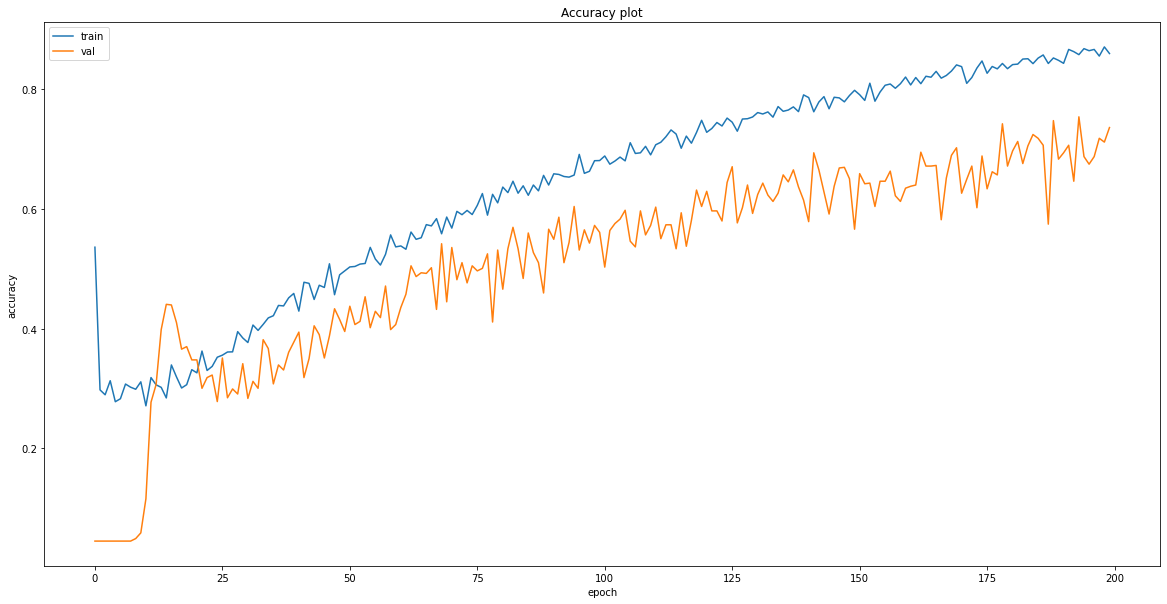

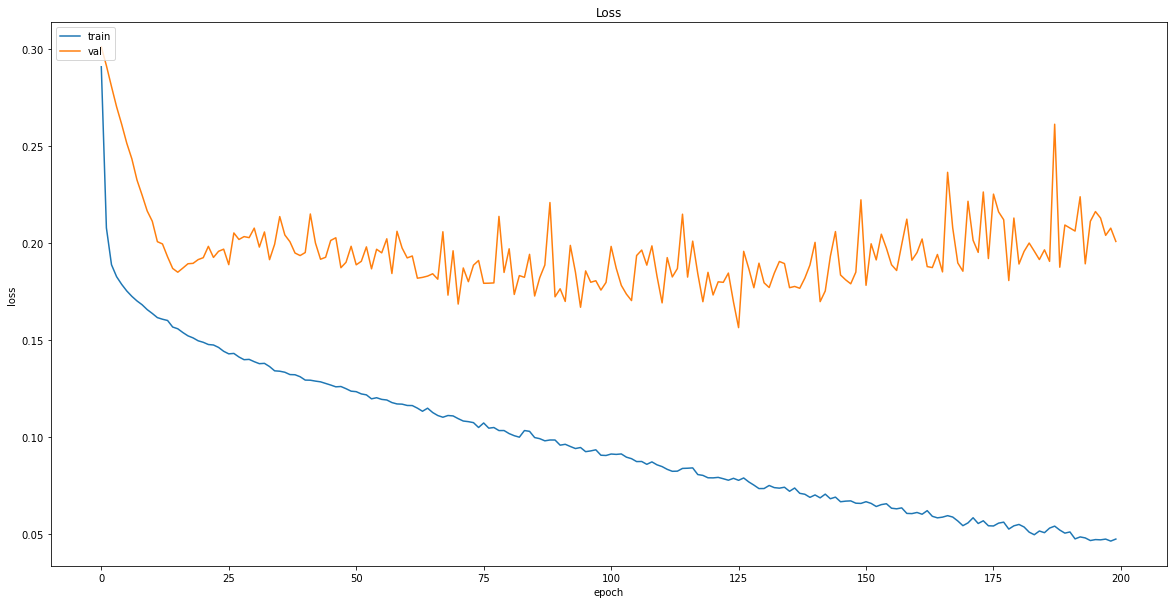

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
# Save model
model.save("models/{}".format('WMT_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/WMT_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [128]:
logger = []

In [129]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [130]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [131]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [132]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [133]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1775 - accuracy: 0.7936 - mean_squared_error: 7.0856 - weighted_accuracy: 0.7936 - weighted_mean_squared_error: 7.0856
Test loss: 0.17746032774448395
Test accuracy: 0.7935779690742493


In [134]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 186, 0: 17, 1: 15})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [136]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [137]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


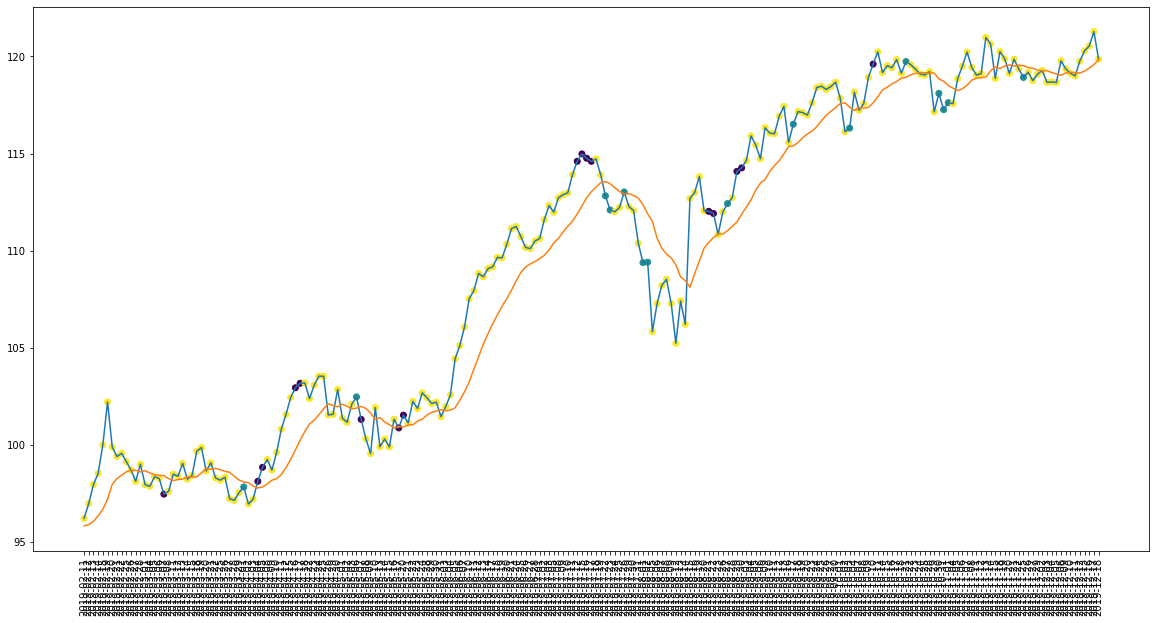

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

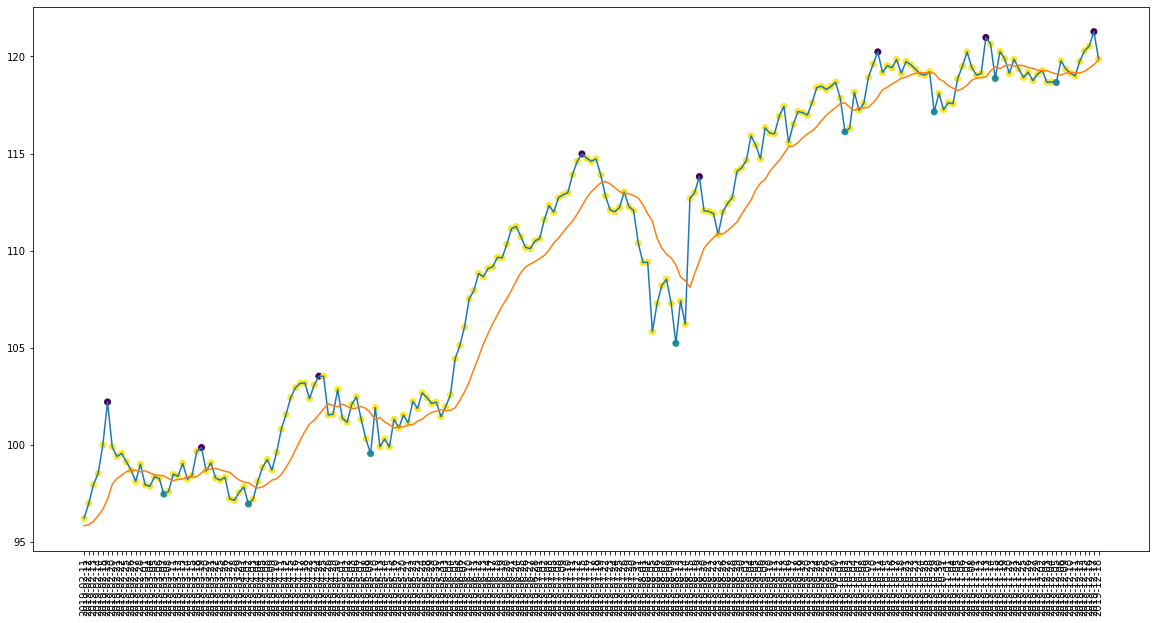

In [139]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [140]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 15
actual holds but predicted sell: 15
actual predicted holds: 172
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 85.14851485148515%
actual buys: 8
actual sells: 8
actual holds: 202


In [141]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 52.94117647058823%
Percentage holds correct: 84.86486486486487%


In [142]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $97.81999969482422
Shares owned at the moment: 101
Cash capital at the moment: $93.01052590751533


Price increase from previously bought: 5.169793478835594%
Share price: $103.16000366210938
Shares owned at the moment: 0
Cash capital at the moment: $10483.518204763412


Share price: $102.45999908447266
Shares owned at the moment: 102
Cash capital at the moment: $3.858268404006594


Stop Loss Activated!

Share price: $99.54000091552734
Shares owned at the moment: 0
Cash capital at the moment: $10129.01739153099


Share price: $112.81999969482422
Shares owned at the moment: 89
Cash capital at the moment: $60.42472376632577


Stop Loss Activated!

Share price: $109.37999725341795
Shares owned at the moment: 0
Cash capital at the moment: $9768.47372499275


Share price: $109.37999725341795
Shares owned at the moment: 89
Cash capital at the moment: $6.88321511077811


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment

In [143]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [144]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%
2,0.768116,0.0%,50.0%,82.79569892473118%,61.111111111111114%,63.1578947368421%,79.28994082840237%,6.441581239719417%,24.380335833320625%
3,0.740385,14.285714285714286%,0.0%,79.27461139896373%,57.89473684210526%,65.21739130434783%,84.24242424242425%,17.37873939679137%,64.87407351390837%
4,0.793578,0.0%,12.5%,85.14851485148515%,53.333333333333336%,52.94117647058823%,84.86486486486487%,-1.0141647599601673%,23.7578138288879%


### Recession

In [145]:
logger = []

In [146]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [147]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [148]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [149]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [150]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1311 - accuracy: 0.8265 - mean_squared_error: 6.7392 - weighted_accuracy: 0.8265 - weighted_mean_squared_error: 6.7392
Test loss: 0.13114678859710693
Test accuracy: 0.8264840245246887


In [151]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 0: 13, 1: 15})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [153]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [154]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


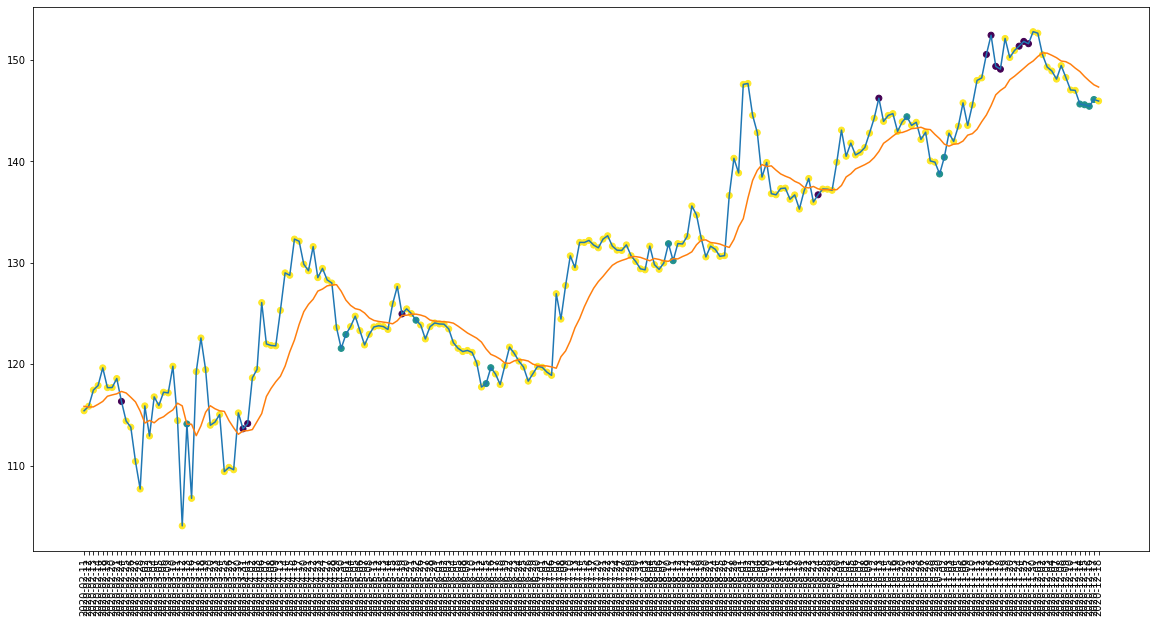

In [155]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

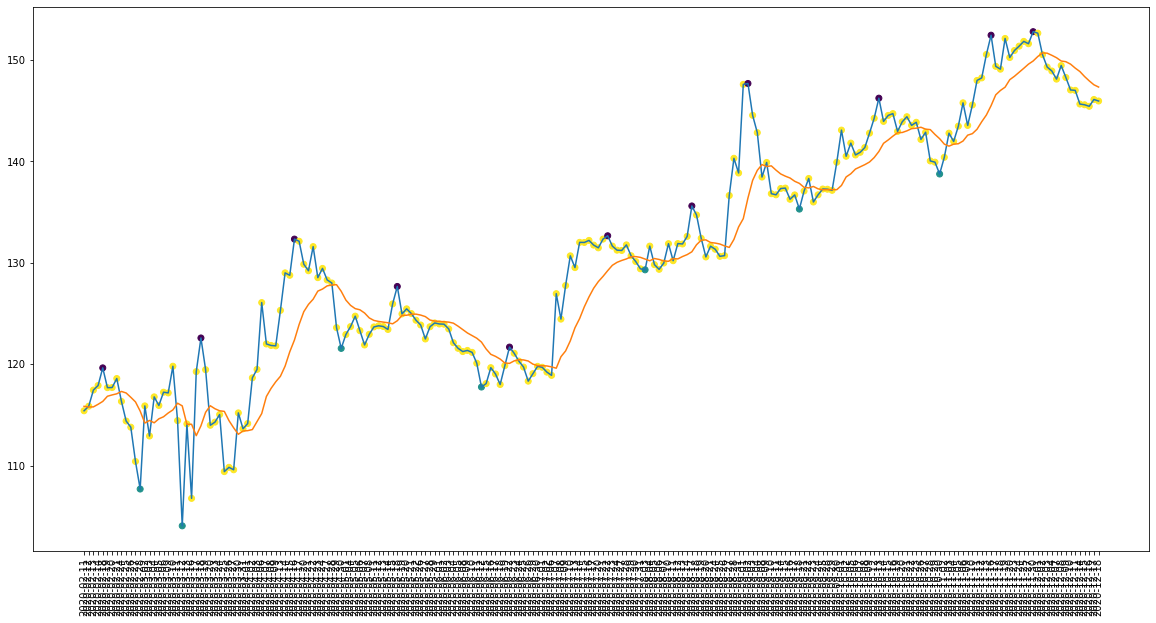

In [156]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [157]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 13
actual holds but predicted sell: 11
actual predicted holds: 177
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 88.05970149253731%
actual buys: 7
actual sells: 11
actual holds: 201


In [158]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 38.46153846153846%
Percentage holds correct: 85.78947368421052%


In [159]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $114.0999984741211
Shares owned at the moment: 87
Cash capital at the moment: $46.00170811653152


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9308.579563457492


Share price: $121.5500030517578
Shares owned at the moment: 76
Cash capital at the moment: $45.375380886081984


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $8969.007558979036


Share price: $118.08000183105469
Shares owned at the moment: 75
Cash capital at the moment: $88.65342127227814


Price increase from previously bought: 15.451474255797514%
Share price: $136.69999694824222
Shares owned at the moment: 0
Cash capital at the moment: $10312.958818019868


Share price: $144.39999389648438
Shares owned at the moment: 71
Cash capital at the moment: $32.36515256118764


Stop Loss Activated!

Share price: $140.03999328613278
Shares owned at the moment: 0
Cash capital at the mome

In [160]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [161]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%
2,0.768116,0.0%,50.0%,82.79569892473118%,61.111111111111114%,63.1578947368421%,79.28994082840237%,6.441581239719417%,24.380335833320625%
3,0.740385,14.285714285714286%,0.0%,79.27461139896373%,57.89473684210526%,65.21739130434783%,84.24242424242425%,17.37873939679137%,64.87407351390837%
4,0.793578,0.0%,12.5%,85.14851485148515%,53.333333333333336%,52.94117647058823%,84.86486486486487%,-1.0141647599601673%,23.7578138288879%
5,0.826484,28.571428571428573%,18.181818181818183%,88.05970149253731%,66.66666666666667%,38.46153846153846%,85.78947368421052%,6.91829043930049%,25.65490331684112%


## Fresh Del Monte Produce Inc

In [162]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


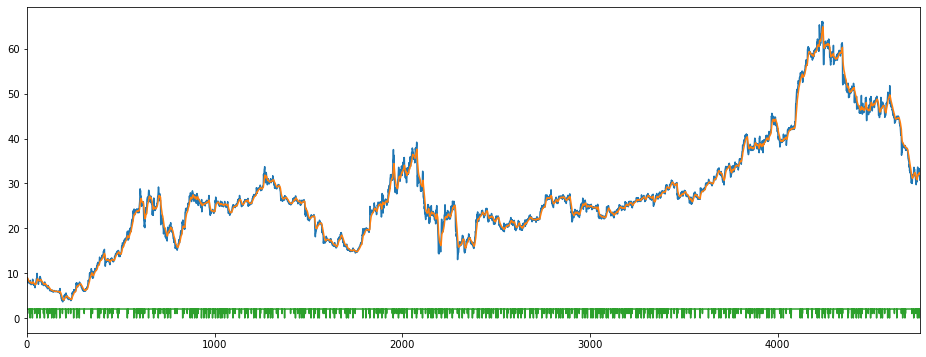

In [163]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [165]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [166]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 41ms/step - loss: 0.2936 - accuracy: 0.5269 - mse: 0.4583 - weighted_accuracy: 0.3054 - weighted_mse: 0.5492 - val_loss: 0.3001 - val_accuracy: 0.0464 - val_mse: 0.3507 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3507
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2130 - accuracy: 0.3872 - mse: 0.7736 - weighted_accuracy: 0.4152 - weighted_mse: 0.7820 - val_loss: 0.2903 - val_accuracy: 0.0464 - val_mse: 0.3798 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3798
Epoch 3/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1921 - accuracy: 0.3425 - mse: 0.9932 - weighted_accuracy: 0.4529 - weighted_mse: 0.9845 - val_loss: 0.2789 - val_accuracy: 0.0464 - val_mse: 0.4169 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4169
Epoch 4/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1834 - accuracy: 0.3109 - mse: 1.1370 - weighted_accuracy: 0.4810 - weig

Epoch 30/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1510 - accuracy: 0.3248 - mse: 1.5132 - weighted_accuracy: 0.6453 - weighted_mse: 1.4286 - val_loss: 0.1882 - val_accuracy: 0.3446 - val_mse: 1.5119 - val_weighted_accuracy: 0.3446 - val_weighted_mse: 1.5119
Epoch 31/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1503 - accuracy: 0.3606 - mse: 1.5057 - weighted_accuracy: 0.6548 - weighted_mse: 1.4267 - val_loss: 0.1935 - val_accuracy: 0.3003 - val_mse: 1.5698 - val_weighted_accuracy: 0.3003 - val_weighted_mse: 1.5698
Epoch 32/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1487 - accuracy: 0.3617 - mse: 1.5287 - weighted_accuracy: 0.6590 - weighted_mse: 1.4456 - val_loss: 0.1896 - val_accuracy: 0.3498 - val_mse: 1.4991 - val_weighted_accuracy: 0.3498 - val_weighted_mse: 1.4991
Epoch 33/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1483 - accuracy: 0.3667 - mse: 1.5129 - weighted_accuracy: 0.6608 - 

Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1318 - accuracy: 0.4860 - mse: 1.7495 - weighted_accuracy: 0.7372 - weighted_mse: 1.6947 - val_loss: 0.1816 - val_accuracy: 0.4510 - val_mse: 1.7778 - val_weighted_accuracy: 0.4510 - val_weighted_mse: 1.7778
Epoch 60/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1310 - accuracy: 0.4729 - mse: 1.7569 - weighted_accuracy: 0.7430 - weighted_mse: 1.6778 - val_loss: 0.1832 - val_accuracy: 0.4320 - val_mse: 1.8914 - val_weighted_accuracy: 0.4320 - val_weighted_mse: 1.8914
Epoch 61/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1301 - accuracy: 0.4729 - mse: 1.7822 - weighted_accuracy: 0.7394 - weighted_mse: 1.7075 - val_loss: 0.1809 - val_accuracy: 0.4478 - val_mse: 1.8625 - val_weighted_accuracy: 0.4478 - val_weighted_mse: 1.8625
Epoch 62/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1300 - accuracy: 0.4997 - mse: 1.8124 - weighted_accuracy: 0.7276 - 

30/30 [==============================] - 0s 11ms/step - loss: 0.1143 - accuracy: 0.5996 - mse: 2.0896 - weighted_accuracy: 0.8077 - weighted_mse: 2.0472 - val_loss: 0.1819 - val_accuracy: 0.4795 - val_mse: 2.2987 - val_weighted_accuracy: 0.4795 - val_weighted_mse: 2.2987
Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1129 - accuracy: 0.5835 - mse: 2.1219 - weighted_accuracy: 0.8054 - weighted_mse: 2.0666 - val_loss: 0.1849 - val_accuracy: 0.4942 - val_mse: 2.0889 - val_weighted_accuracy: 0.4942 - val_weighted_mse: 2.0889
Epoch 89/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1131 - accuracy: 0.5854 - mse: 2.1598 - weighted_accuracy: 0.8007 - weighted_mse: 2.1165 - val_loss: 0.1719 - val_accuracy: 0.5564 - val_mse: 2.2170 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 2.2170
Epoch 90/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1116 - accuracy: 0.5940 - mse: 2.1341 - weighted_accuracy: 0.8075 - weighted_mse:

30/30 [==============================] - 0s 11ms/step - loss: 0.0966 - accuracy: 0.6828 - mse: 2.6124 - weighted_accuracy: 0.8401 - weighted_mse: 2.6131 - val_loss: 0.2036 - val_accuracy: 0.4963 - val_mse: 2.8061 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 2.8061
Epoch 116/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0951 - accuracy: 0.6707 - mse: 2.6362 - weighted_accuracy: 0.8573 - weighted_mse: 2.6105 - val_loss: 0.1570 - val_accuracy: 0.6386 - val_mse: 2.7369 - val_weighted_accuracy: 0.6386 - val_weighted_mse: 2.7369
Epoch 117/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0941 - accuracy: 0.6899 - mse: 2.6261 - weighted_accuracy: 0.8517 - weighted_mse: 2.6373 - val_loss: 0.1669 - val_accuracy: 0.5880 - val_mse: 2.8132 - val_weighted_accuracy: 0.5880 - val_weighted_mse: 2.8132
Epoch 118/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0943 - accuracy: 0.6625 - mse: 2.6980 - weighted_accuracy: 0.8489 - weighted_m

Epoch 144/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0806 - accuracy: 0.7426 - mse: 3.2853 - weighted_accuracy: 0.8874 - weighted_mse: 3.3021 - val_loss: 0.1743 - val_accuracy: 0.6017 - val_mse: 3.6500 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 3.6500
Epoch 145/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0822 - accuracy: 0.7300 - mse: 3.3450 - weighted_accuracy: 0.8827 - weighted_mse: 3.3772 - val_loss: 0.1869 - val_accuracy: 0.5890 - val_mse: 3.1908 - val_weighted_accuracy: 0.5890 - val_weighted_mse: 3.1908
Epoch 146/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0813 - accuracy: 0.7471 - mse: 3.3741 - weighted_accuracy: 0.8836 - weighted_mse: 3.3880 - val_loss: 0.1787 - val_accuracy: 0.6238 - val_mse: 3.4393 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 3.4393
Epoch 147/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0789 - accuracy: 0.7442 - mse: 3.3408 - weighted_accuracy: 0.891

Epoch 173/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0676 - accuracy: 0.7956 - mse: 4.1861 - weighted_accuracy: 0.9050 - weighted_mse: 4.2264 - val_loss: 0.1690 - val_accuracy: 0.6744 - val_mse: 4.4502 - val_weighted_accuracy: 0.6744 - val_weighted_mse: 4.4502
Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.8185 - mse: 4.3375 - weighted_accuracy: 0.9243 - weighted_mse: 4.3287 - val_loss: 0.1604 - val_accuracy: 0.7355 - val_mse: 4.5490 - val_weighted_accuracy: 0.7355 - val_weighted_mse: 4.5490
Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.8040 - mse: 4.4172 - weighted_accuracy: 0.9117 - weighted_mse: 4.4087 - val_loss: 0.1479 - val_accuracy: 0.7239 - val_mse: 4.5285 - val_weighted_accuracy: 0.7239 - val_weighted_mse: 4.5285
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.7969 - mse: 4.3933 - weighted_accuracy: 0.9146 - 

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.16631922125816345
Test accuracy: 0.7186512351036072


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.4410887  -1.6130227   0.9398245 ]
 [ 0.01283751 -2.4230092  -0.87348324]
 [-0.9698114  -3.4075646  -0.03581516]
 ...
 [-1.6674056  -3.1878335   0.8972102 ]
 [-0.17376174 -2.8700085  -0.4670266 ]
 [ 0.42110047 -2.6464427  -1.0643716 ]]


Counter({2: 737, 0: 120, 1: 92})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 37
actual holds but predicted buy: 81
actual holds but predicted sell: 114
actual predicted holds: 667
Percentage buys correct: 22.727272727272727%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 77.37819025522042%
actual buys: 44
actual sells: 43
actual holds: 862


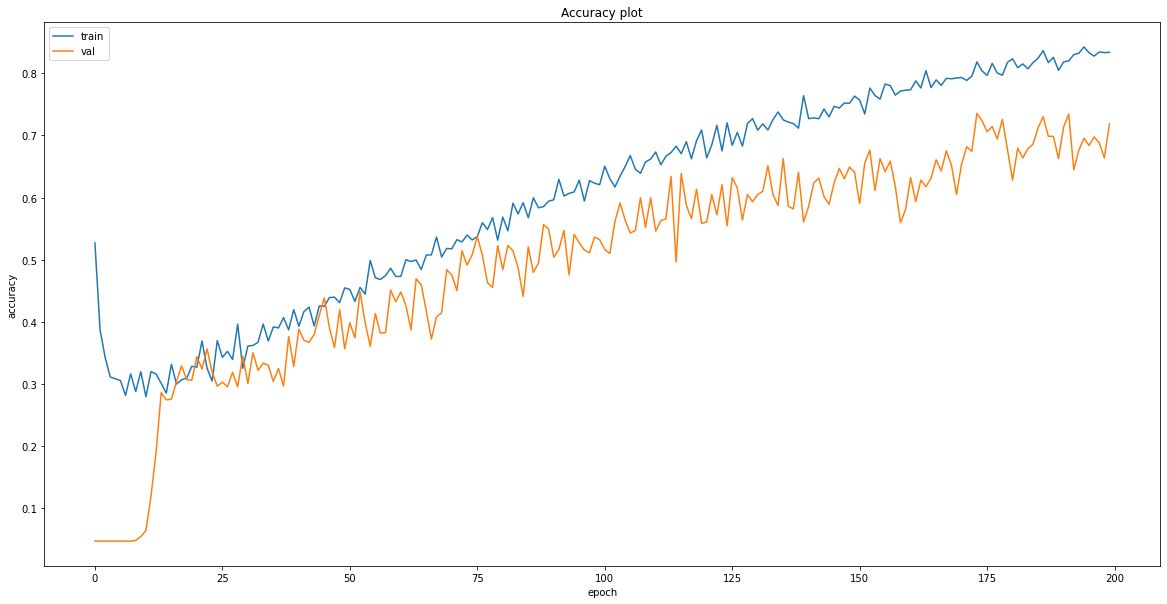

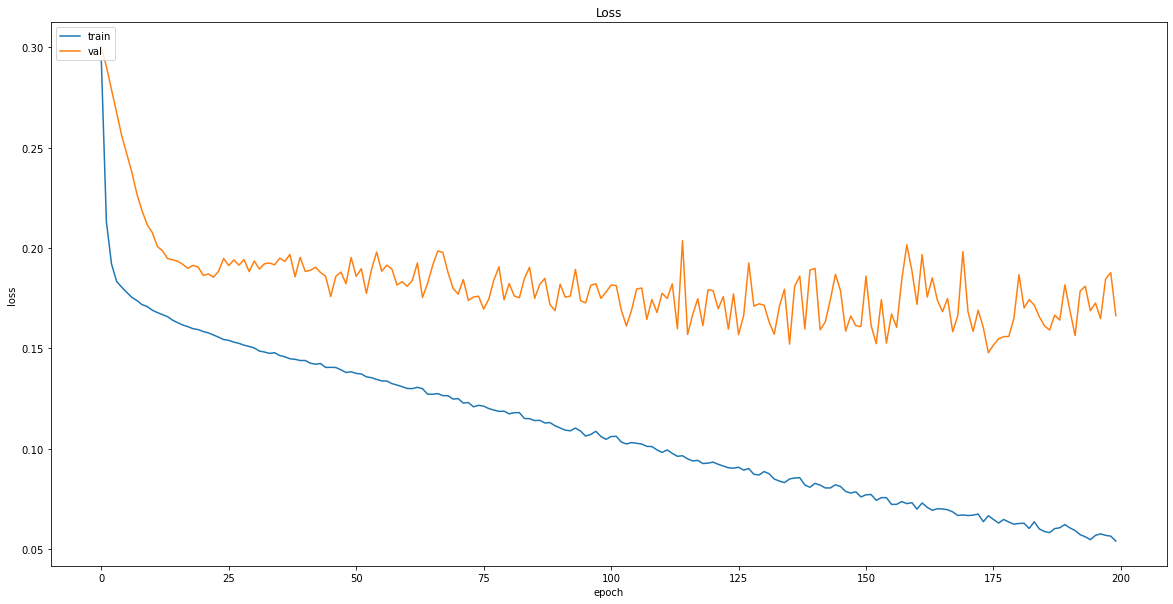

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [178]:
logger = []

In [179]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [180]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [182]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [183]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1912 - accuracy: 0.6835 - mean_squared_error: 5.8958 - weighted_accuracy: 0.6835 - weighted_mean_squared_error: 5.8958
Test loss: 0.19120104610919952
Test accuracy: 0.6834862232208252


In [184]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 38, 2: 151, 1: 29})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [186]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [187]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,0,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,0,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,0,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,0,0


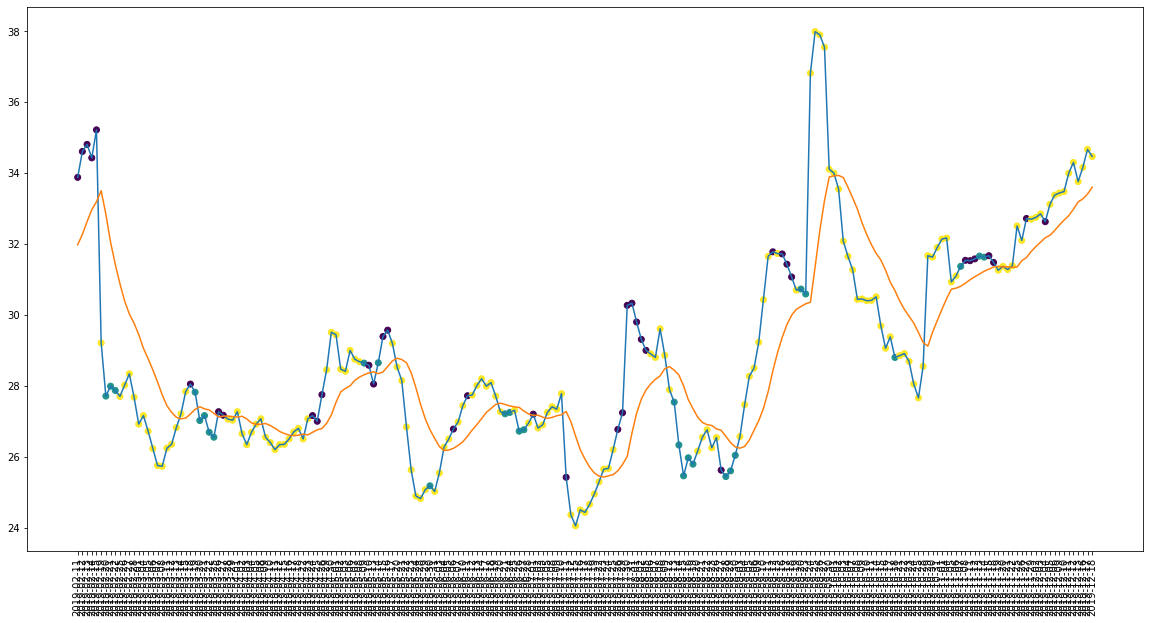

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

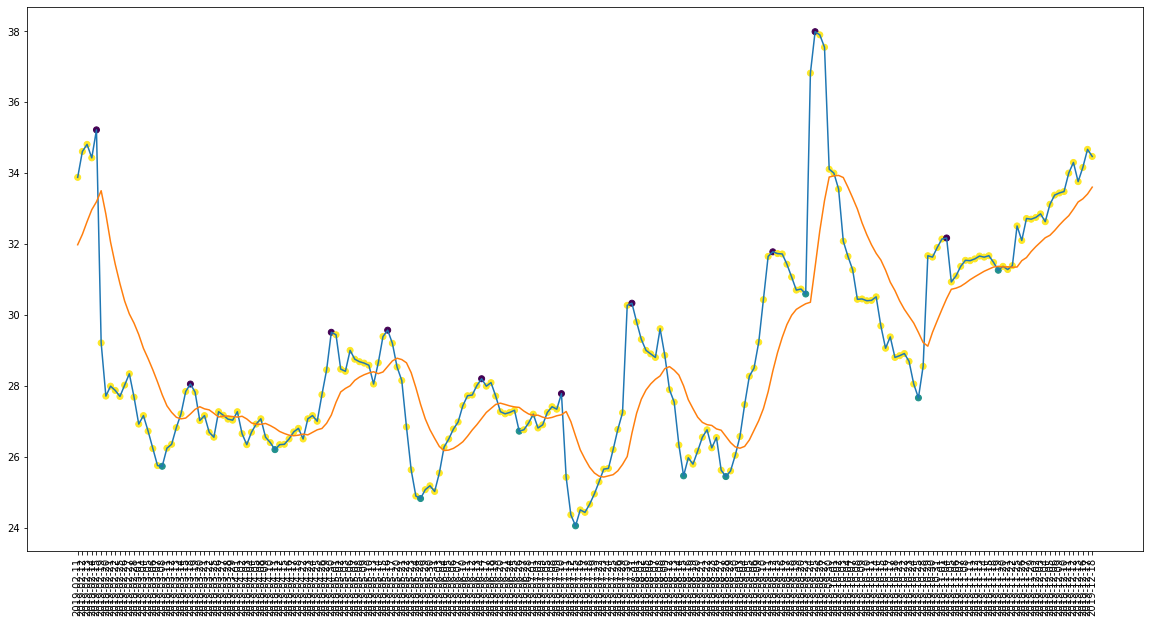

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [190]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 25
actual holds but predicted sell: 33
actual predicted holds: 140
Percentage buys correct: 40.0%
Percentage sells correct: 50.0%
Percentage holds correct: 70.70707070707071%
actual buys: 10
actual sells: 10
actual holds: 198


In [191]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 72.41379310344827%
Percentage sells correct: 50.0%
Percentage holds correct: 86.0%


In [192]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.709999084472656
Shares owned at the moment: 359
Cash capital at the moment: $24.753632078170995


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9662.456889392375


Share price: $27.81999969482422
Shares owned at the moment: 346
Cash capital at the moment: $10.266265273570752


Stop Loss Activated!

Share price: $27.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9333.476893224239


Share price: $27.020000457763672
Shares owned at the moment: 344
Cash capital at the moment: $13.035815320490656


Stop Loss Activated!

Share price: $26.20000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9001.05087704992


Share price: $28.63999938964844
Shares owned at the moment: 313
Cash capital at the moment: $12.079188615316525


Stop Loss Activated!

Share price: $26.84000015258789
Shares owned at the moment: 0
Cash capital at the moment: $8389.896706243986


Share pri

In [193]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [194]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%
2,0.768116,0.0%,50.0%,82.79569892473118%,61.111111111111114%,63.1578947368421%,79.28994082840237%,6.441581239719417%,24.380335833320625%
3,0.740385,14.285714285714286%,0.0%,79.27461139896373%,57.89473684210526%,65.21739130434783%,84.24242424242425%,17.37873939679137%,64.87407351390837%
4,0.793578,0.0%,12.5%,85.14851485148515%,53.333333333333336%,52.94117647058823%,84.86486486486487%,-1.0141647599601673%,23.7578138288879%
5,0.826484,28.571428571428573%,18.181818181818183%,88.05970149253731%,66.66666666666667%,38.46153846153846%,85.78947368421052%,6.91829043930049%,25.65490331684112%
6,0.683486,40.0%,50.0%,70.70707070707071%,72.41379310344827%,50.0%,86.0%,-6.129910997958286%,1.1819906801032993%


### recession

In [195]:
logger = []

In [196]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [197]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [198]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1636 - accuracy: 0.7443 - mean_squared_error: 5.1807 - weighted_accuracy: 0.7443 - weighted_mean_squared_error: 5.1807
Test loss: 0.1635545939207077
Test accuracy: 0.7442922592163086


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 26, 2: 177, 1: 16})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [204]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


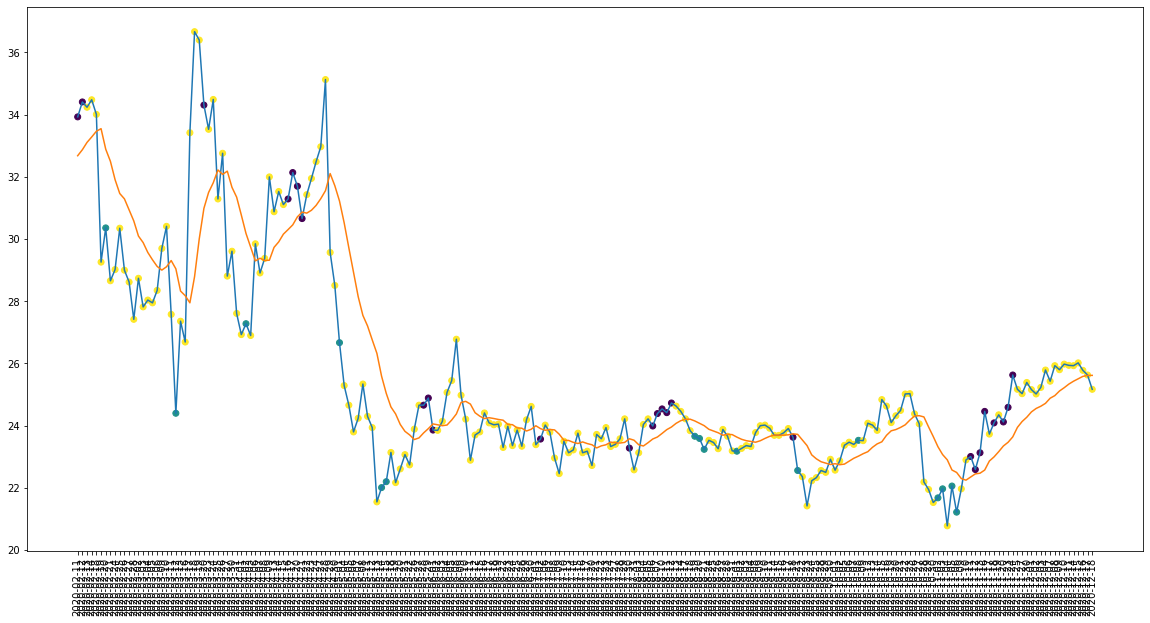

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

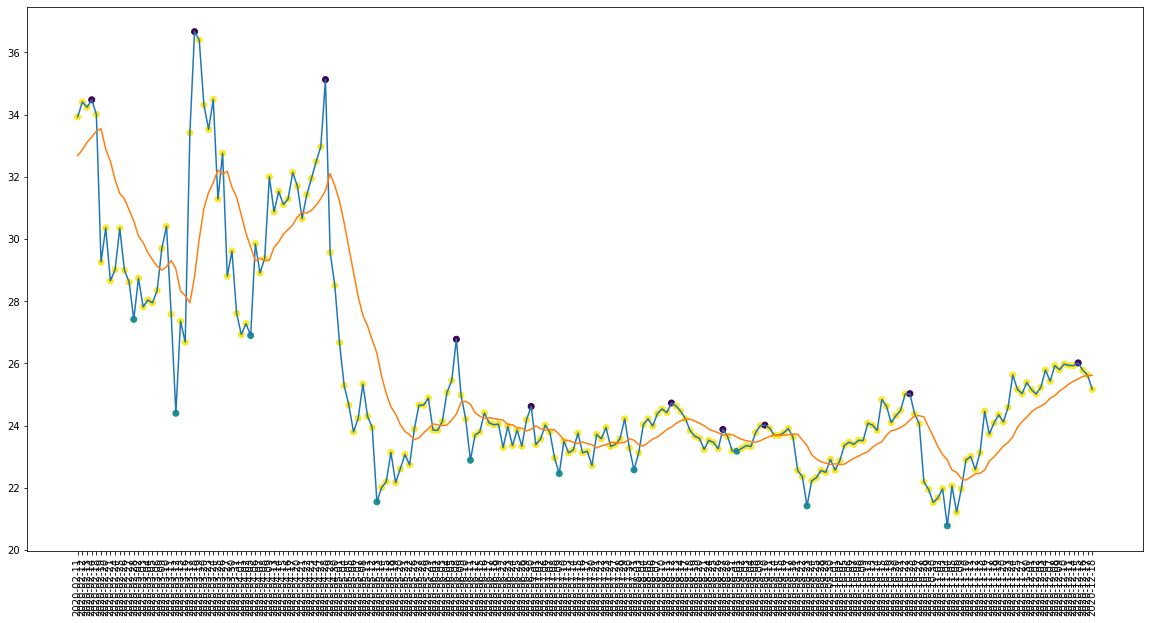

In [206]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [207]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 14
actual holds but predicted sell: 25
actual predicted holds: 160
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 80.40201005025126%
actual buys: 10
actual sells: 10
actual holds: 199


In [208]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 50.0%
Percentage sells correct: 42.30769230769231%
Percentage holds correct: 82.95454545454545%


In [209]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.36000061035156
Shares owned at the moment: 328
Cash capital at the moment: $14.535079254152151


Stop Loss Activated!

Share price: $28.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9389.163709342958


Share price: $24.399999618530273
Shares owned at the moment: 383
Cash capital at the moment: $18.26455584764699


Price increase from previously bought: 40.22913181249008%
Share price: $34.310001373291016
Shares owned at the moment: 0
Cash capital at the moment: $13122.858072871686


Share price: $27.28000068664551
Shares owned at the moment: 479
Cash capital at the moment: $19.803163064001637


Price increase from previously bought: 14.384855605841128%
Share price: $31.290000915527344
Shares owned at the moment: 0
Cash capital at the moment: $14966.49684789562


Share price: $26.670000076293945
Shares owned at the moment: 559
Cash capital at the moment: $16.968347630021526


Stop Loss Activated!

Share price: $25.290000915527344
Shares owned 

In [210]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [211]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.772947,9.090909090909092%,45.45454545454545%,83.24324324324324%,88.88888888888889%,65.51724137931035%,86.3905325443787%,35.75893498504638%,55.56771999603271%
1,0.673077,44.44444444444444%,0.0%,71.95767195767196%,77.77777777777777%,45.0%,84.0%,14.779488953246982%,67.54069125000002%
2,0.768116,0.0%,50.0%,82.79569892473118%,61.111111111111114%,63.1578947368421%,79.28994082840237%,6.441581239719417%,24.380335833320625%
3,0.740385,14.285714285714286%,0.0%,79.27461139896373%,57.89473684210526%,65.21739130434783%,84.24242424242425%,17.37873939679137%,64.87407351390837%
4,0.793578,0.0%,12.5%,85.14851485148515%,53.333333333333336%,52.94117647058823%,84.86486486486487%,-1.0141647599601673%,23.7578138288879%
5,0.826484,28.571428571428573%,18.181818181818183%,88.05970149253731%,66.66666666666667%,38.46153846153846%,85.78947368421052%,6.91829043930049%,25.65490331684112%
6,0.683486,40.0%,50.0%,70.70707070707071%,72.41379310344827%,50.0%,86.0%,-6.129910997958286%,1.1819906801032993%
7,0.744292,20.0%,10.0%,80.40201005025126%,50.0%,42.30769230769231%,82.95454545454545%,29.910973518195043%,-26.14299892369747%


In [212]:
experiment

'No willr LSTM Time Series - noncyclic'

In [213]:
log.to_csv('{}.csv'.format(experiment))